In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import yfinance as yf
from pykrx import stock
from tqdm import tqdm

In [220]:
import pandas as pd

def yoy_transform(dataframe, value_column):
    """
    분기별 데이터프레임을 Year-over-Year (YoY) 변환하는 함수

    Parameters:
    - dataframe: 분기별 데이터프레임 (날짜 열이 인덱스로 설정되어 있어야 함)
    - value_column: 변환할 값의 열 이름

    Returns:
    - 변환된 데이터프레임
    """
    # 데이터를 분기로 리샘플링하고 YoY 변환
    yoy_data = dataframe.resample('Q').sum().pct_change(periods=4)[value_column] * 100

    # 원래 데이터프레임과 병합
    dataframe = pd.concat([dataframe, yoy_data.rename(f'{value_column}_YoY')], axis=1)

    return dataframe


In [221]:
kospi = fdr.DataReader('KS11', '1980-01-01', '2023-10-01')['Adj Close']

In [222]:
market = pd.DataFrame(kospi.resample('Q').last())
market.columns = ['kospi']

In [268]:
q_pct_market = yoy_transform(market, 'kospi')
q_pct_market = q_pct_market.drop('kospi', axis=1)
q_pct_market = q_pct_market.dropna()
q_pct_market.columns = ['kospi']

In [269]:
q_pct_market

,kospi
Date,
1997-12-31,-42.392738
1998-03-31,-28.981015
1998-06-30,-60.037564
1998-09-30,-52.045245
1998-12-31,49.929370
...,...
2022-09-30,-29.761604
2022-12-31,-24.893793
2023-03-31,-10.182213


In [270]:
#q_pct_market = market.pct_change()[1:]

In [271]:
type(q_pct_market.index)

pandas.core.indexes.datetimes.DatetimeIndex

<AxesSubplot:xlabel='Date'>

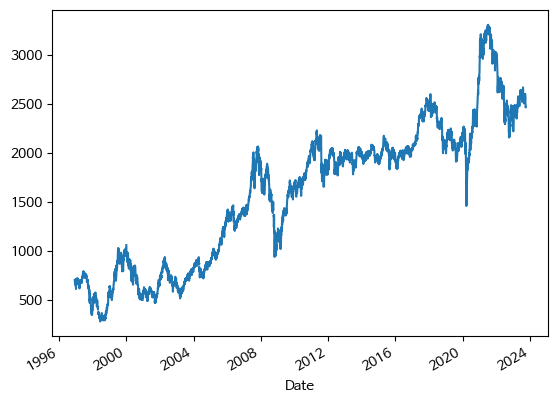

In [272]:
kospi.plot()

In [273]:
gdp = pd.read_csv('GDP.csv').T[1:]
gdp.columns = ['gdp','pct_real_gdp']

In [274]:
gdp.index

Index(['19801/4', '19802/4', '19803/4', '19804/4', '19811/4', '19812/4',
       '19813/4', '19814/4', '19821/4', '19822/4',
       ...
       '20211/4', '20212/4', '20213/4', '20214/4', '20221/4', '20222/4',
       '20223/4', '20224/4', '20231/4', '20232/4'],
      dtype='object', length=174)

In [275]:
date_index = []
for i in gdp.index:
    years = i[:4]
    q = i[4:]
    if q == '1/4':
        q = '-03-31'
    elif q == '2/4':
        q = '-06-30'
    elif q == '3/4':
        q = '-09-30'
    elif q == '4/4':
        q = '-12-31'

    txt = str(years) + q
    date_index.append(txt)

date = pd.to_datetime(pd.Series(date_index))

In [276]:
gdp.index = date

In [277]:
dataset = pd.concat([gdp, q_pct_market], axis=1).dropna()

In [278]:
series = dataset['gdp'].str.replace(',', '').astype(float)
dataset['gdp'] = series

In [279]:
dataset = dataset.astype(float)

In [280]:
dataset['pct_real_gdp']

1997-12-31    4.3
1998-03-31   -2.9
1998-06-30   -7.2
1998-09-30   -6.4
1998-12-31   -3.8
             ... 
2022-06-30    2.9
2022-09-30    3.2
2022-12-31    1.4
2023-03-31    0.9
2023-06-30    0.9
Freq: Q-DEC, Name: pct_real_gdp, Length: 103, dtype: float64

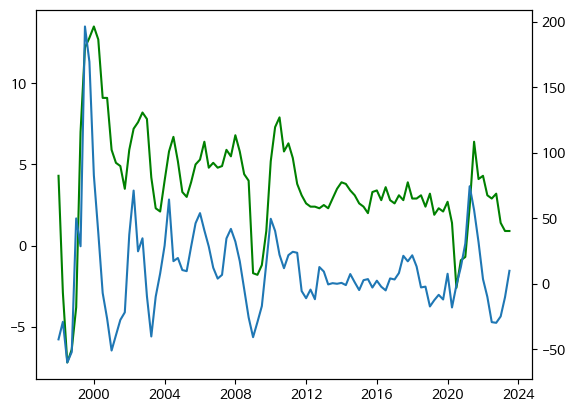

In [281]:
fig, ax1 = plt.subplots()
ax1.plot(dataset.index, dataset['pct_real_gdp'],color='g')
ax2 = ax1.twinx()
ax2.plot(dataset.index, dataset['kospi'])

plt.show()

In [282]:
import statsmodels.api as sm

df = dataset

# 독립 변수와 종속 변수 정의
X = df['pct_real_gdp']
y = df['kospi']

# 회귀 모델 생성
X = sm.add_constant(X)  # 상수항을 추가합니다.
model = sm.OLS(y, X).fit()

# 회귀 결과 요약
print(model.summary())

# 회귀 계수 확인
print("회귀 계수 (slope):", model.params['pct_real_gdp'])
print("절편 (intercept):", model.params['const'])


                            OLS Regression Results                            
Dep. Variable:                  kospi   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     49.03
Date:                Sun, 01 Oct 2023   Prob (F-statistic):           2.85e-10
Time:                        16:57:57   Log-Likelihood:                -497.01
No. Observations:                 103   AIC:                             998.0
Df Residuals:                     101   BIC:                             1003.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -13.4770      4.518     -2.983   

In [283]:
cpi = pd.read_csv('CPI.csv').T[1:]
cpi.columns = ['cpi','core_cpi']

In [284]:
cpi

,cpi,core_cpi
199703월,4.5,3.2
199704월,4.3,3.0
199705월,3.8,3.0
199706월,4.0,3.0
199707월,3.7,3.1
...,...,...
202304월,3.7,4.6
202305월,3.3,4.3
202306월,2.7,4.1
202307월,2.3,3.9


In [285]:
index = []
date_index = []
for k, i in enumerate(cpi.index):
    years = i[:4]
    q = i[4:6]
    if q == '03':
        txt = str(years) + '-' + q + '-' + '31'
        index.append(k)
        date_index.append(txt)
    elif q == '06':
        txt = str(years) + '-' + q + '-' + '30'
        index.append(k)
        date_index.append(txt)
    elif q == '09':
        txt = str(years) + '-' + q + '-' + '30'
        index.append(k)
        date_index.append(txt)
    elif q == '12':
        txt = str(years) + '-' + q + '-' + '31'
        index.append(k)
        date_index.append(txt)

date = pd.to_datetime(pd.Series(date_index))

In [286]:
cpi_data = cpi.iloc[index]
cpi_data.index = date
cpi_data = cpi_data.astype(float)

In [287]:
cpi_data

,cpi,core_cpi
1997-03-31,4.5,3.2
1997-06-30,4.0,3.0
1997-09-30,4.2,3.7
1997-12-31,6.6,4.2
1998-03-31,9.0,7.4
...,...,...
2022-06-30,6.0,4.4
2022-09-30,5.6,4.5
2022-12-31,5.0,4.8
2023-03-31,4.2,4.8


In [288]:
result = dataset.join([cpi_data])
result

,gdp,pct_real_gdp,kospi,cpi,core_cpi
1997-12-31,146874.9,4.3,-42.392738,6.6,4.2
1998-03-31,131111.0,-2.9,-28.981015,9.0,7.4
1998-06-30,131834.6,-7.2,-60.037564,7.5,6.6
1998-09-30,134676.5,-6.4,-52.045245,6.9,4.8
1998-12-31,139593.3,-3.8,49.929370,4.0,4.0
...,...,...,...,...,...
2022-06-30,544239.8,2.9,-29.242755,6.0,4.4
2022-09-30,548892.5,3.2,-29.761604,5.6,4.5
2022-12-31,556628.7,1.4,-24.893793,5.0,4.8
2023-03-31,523816.2,0.9,-10.182213,4.2,4.8


In [289]:
result

,gdp,pct_real_gdp,kospi,cpi,core_cpi
1997-12-31,146874.9,4.3,-42.392738,6.6,4.2
1998-03-31,131111.0,-2.9,-28.981015,9.0,7.4
1998-06-30,131834.6,-7.2,-60.037564,7.5,6.6
1998-09-30,134676.5,-6.4,-52.045245,6.9,4.8
1998-12-31,139593.3,-3.8,49.929370,4.0,4.0
...,...,...,...,...,...
2022-06-30,544239.8,2.9,-29.242755,6.0,4.4
2022-09-30,548892.5,3.2,-29.761604,5.6,4.5
2022-12-31,556628.7,1.4,-24.893793,5.0,4.8
2023-03-31,523816.2,0.9,-10.182213,4.2,4.8


In [290]:
import statsmodels.api as sm

df = result
df['cpi'] = df['cpi'].astype(float)

# 독립 변수와 종속 변수 정의
X = df[['pct_real_gdp', 'cpi']]
y = df['kospi']

# 회귀 모델 생성
X = sm.add_constant(X)  # 상수항을 추가합니다.
model = sm.OLS(y, X).fit()

# 회귀 결과 요약
print(model.summary())

# 회귀 계수 확인
print("회귀 계수 (slope):", model.params['pct_real_gdp'])
print("회귀 계수 (slope):", model.params['cpi'])
print("절편 (intercept):", model.params['const'])


                            OLS Regression Results                            
Dep. Variable:                  kospi   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     31.77
Date:                Sun, 01 Oct 2023   Prob (F-statistic):           2.09e-11
Time:                        16:58:01   Log-Likelihood:                -492.06
No. Observations:                 103   AIC:                             990.1
Df Residuals:                     100   BIC:                             998.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.6533      6.914      0.528   

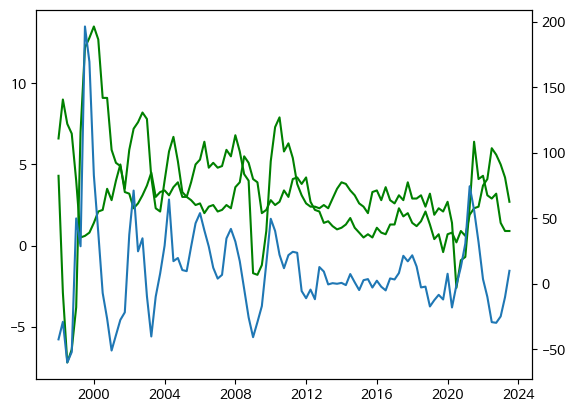

In [291]:
fig, ax1 = plt.subplots()
ax1.plot(result.index, result[['pct_real_gdp', 'cpi']], color='g')
ax2 = ax1.twinx()
ax2.plot(result.index, result['kospi'])

plt.show()

In [292]:
result

,gdp,pct_real_gdp,kospi,cpi,core_cpi
1997-12-31,146874.9,4.3,-42.392738,6.6,4.2
1998-03-31,131111.0,-2.9,-28.981015,9.0,7.4
1998-06-30,131834.6,-7.2,-60.037564,7.5,6.6
1998-09-30,134676.5,-6.4,-52.045245,6.9,4.8
1998-12-31,139593.3,-3.8,49.929370,4.0,4.0
...,...,...,...,...,...
2022-06-30,544239.8,2.9,-29.242755,6.0,4.4
2022-09-30,548892.5,3.2,-29.761604,5.6,4.5
2022-12-31,556628.7,1.4,-24.893793,5.0,4.8
2023-03-31,523816.2,0.9,-10.182213,4.2,4.8


In [296]:
a = model.params['pct_real_gdp'] * result['pct_real_gdp']

In [295]:
b = model.params['cpi'] * result['cpi']

In [300]:
model_output = a + b + model.params['const']

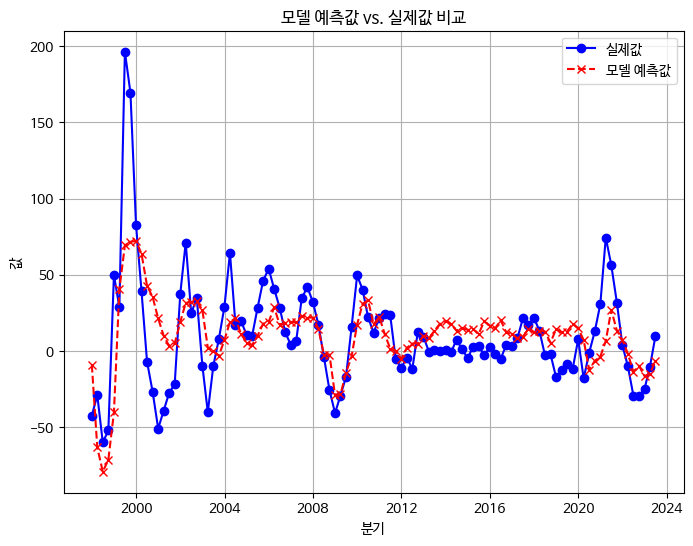

In [303]:
plt.figure(figsize=(8,6))
plt.plot(result.index, result['kospi'], label = '실제값', marker='o', linestyle='-', color='b')
plt.plot(result.index, model_output, label='모델 예측값', marker='x', linestyle='--', color='r')

plt.xlabel('분기')
plt.ylabel('값')
plt.title('모델 예측값 vs. 실제값 비교')
plt.legend()

# 그래프 표시
plt.grid(True)  # 그리드 추가
plt.show()

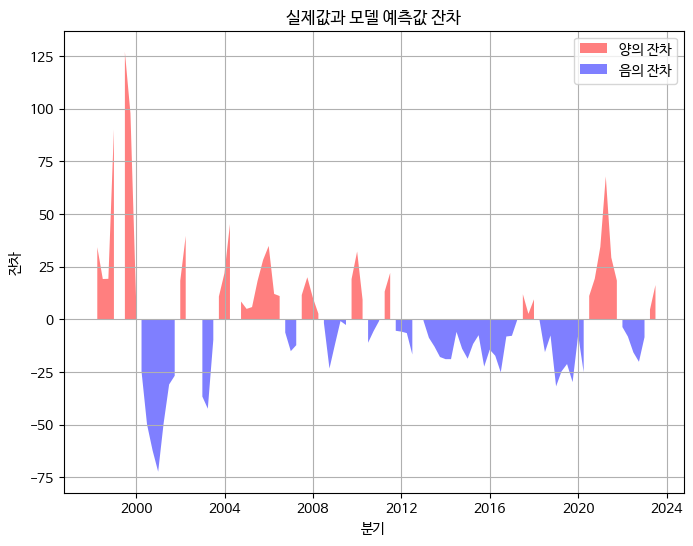

In [305]:
import matplotlib.pyplot as plt
import numpy as np

# 실제값과 모델 예측값 준비 (예시)
actual_values = result['kospi']  # 실제값
predicted_values = model_output  # 모델 예측값

# 잔차 계산
residuals = np.array(actual_values) - np.array(predicted_values)

# 데이터 포인트의 x 좌표 (분기 등)
x_values = result.index

# 잔차 area chart 그리기
plt.figure(figsize=(8, 6))  # 그래프 크기 설정

plt.fill_between(x_values, 0, residuals, where=residuals >= 0, facecolor='red', alpha=0.5, label='양의 잔차')
plt.fill_between(x_values, 0, residuals, where=residuals < 0, facecolor='blue', alpha=0.5, label='음의 잔차')

# 라벨과 범례 추가
plt.xlabel('분기')
plt.ylabel('잔차')
plt.title('실제값과 모델 예측값 잔차')
plt.legend()

# 그래프 표시
plt.grid(True)  # 그리드 추가
plt.show()


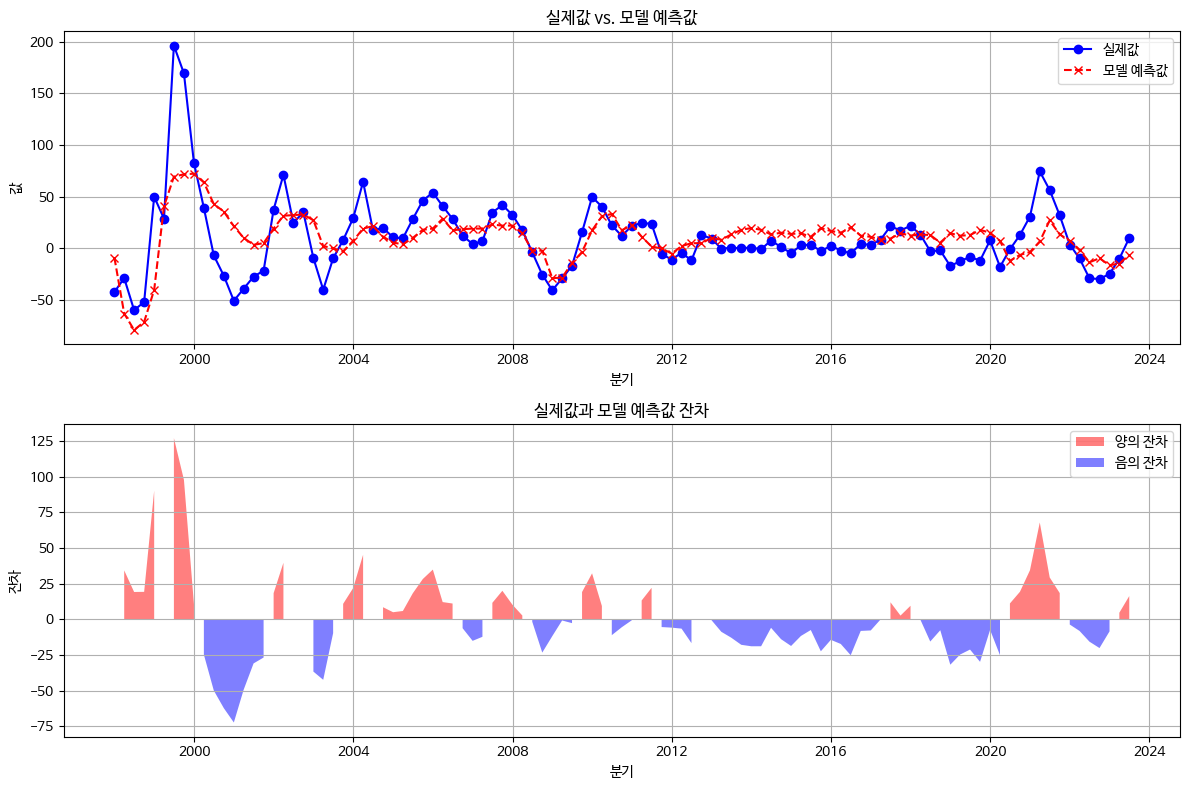

In [307]:
import matplotlib.pyplot as plt
import numpy as np

# 실제값과 모델 예측값 준비 (예시)
actual_values = result['kospi']  # 실제값
predicted_values = model_output  # 모델 예측값

# 잔차 계산
residuals = np.array(actual_values) - np.array(predicted_values)

# 데이터 포인트의 x 좌표 (분기 등)
x_values = result.index

# 두 개의 subplot 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))  # 2개의 subplot을 위아래로 배치

# 첫 번째 subplot (상단)
ax1.plot(x_values, actual_values, label='실제값', marker='o', linestyle='-', color='b')
ax1.plot(x_values, predicted_values, label='모델 예측값', marker='x', linestyle='--', color='r')
ax1.set_xlabel('분기')
ax1.set_ylabel('값')
ax1.set_title('실제값 vs. 모델 예측값')
ax1.legend()
ax1.grid(True)  # 그리드 추가

# 두 번째 subplot (하단)
ax2.fill_between(x_values, 0, residuals, where=residuals >= 0, facecolor='red', alpha=0.5, label='양의 잔차')
ax2.fill_between(x_values, 0, residuals, where=residuals < 0, facecolor='blue', alpha=0.5, label='음의 잔차')
ax2.set_xlabel('분기')
ax2.set_ylabel('잔차')
ax2.set_title('실제값과 모델 예측값 잔차')
ax2.legend()
ax2.grid(True)  # 그리드 추가

# subplot 간의 간격 조정
plt.tight_layout()

# 그래프 표시
plt.show()


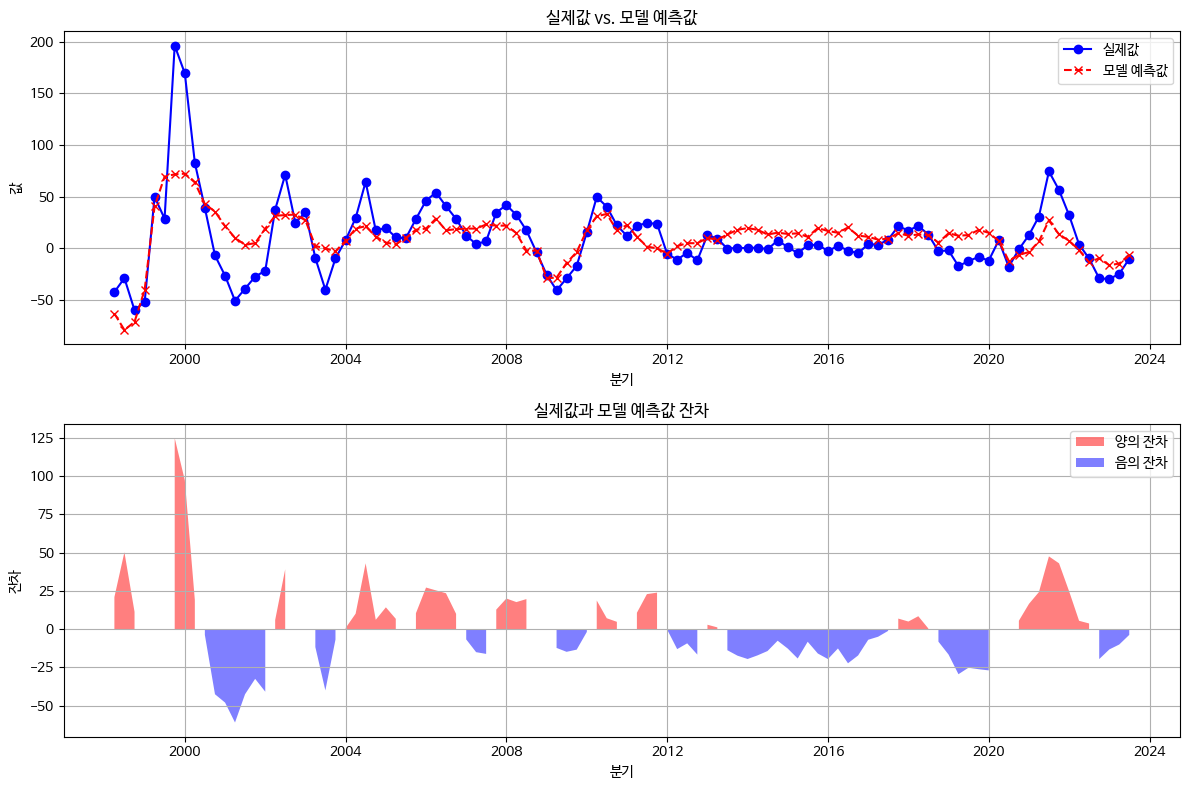

In [329]:
# 1년 래깅 적용
import matplotlib.pyplot as plt
import numpy as np

l = len(result.index)
lag_num = 1

lagged_kospi = result['kospi'][:l-lag_num].to_list()
# 실제값과 모델 예측값 준비 (예시)
actual_values = lagged_kospi  # 실제값
predicted_values = model_output[lag_num:].to_list()  # 모델 예측값

# 잔차 계산
residuals = np.array(actual_values) - np.array(predicted_values)

# 데이터 포인트의 x 좌표 (분기 등)
x_values = result.index[lag_num:]

# 두 개의 subplot 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))  # 2개의 subplot을 위아래로 배치

# 첫 번째 subplot (상단)
ax1.plot(x_values, actual_values, label='실제값', marker='o', linestyle='-', color='b')
ax1.plot(x_values, predicted_values, label='모델 예측값', marker='x', linestyle='--', color='r')
ax1.set_xlabel('분기')
ax1.set_ylabel('값')
ax1.set_title('실제값 vs. 모델 예측값')
ax1.legend()
ax1.grid(True)  # 그리드 추가

# 두 번째 subplot (하단)
ax2.fill_between(x_values, 0, residuals, where=residuals >= 0, facecolor='red', alpha=0.5, label='양의 잔차')
ax2.fill_between(x_values, 0, residuals, where=residuals < 0, facecolor='blue', alpha=0.5, label='음의 잔차')
ax2.set_xlabel('분기')
ax2.set_ylabel('잔차')
ax2.set_title('실제값과 모델 예측값 잔차')
ax2.legend()
ax2.grid(True)  # 그리드 추가

# subplot 간의 간격 조정
plt.tight_layout()

# 그래프 표시
plt.show()


In [323]:
len(result['kospi'][1:].to_list())

102